In [1]:
# Install Kaggle API
!pip install -q kaggle

# Create a directory for Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions for the credentials
!chmod 600 ~/.kaggle/kaggle.json

# Replace 'username/dataset-name' with your dataset name from Kaggle
!kaggle datasets download -d yashmotiani/dogs-skin-disease-dataset

# Unzip the dataset
!unzip /content/dogs-skin-disease-dataset.zip -d /content/dogs-skin-disease-dataset/


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/yashmotiani/dogs-skin-disease-dataset
License(s): CC0-1.0
 99% 186M/188M [00:10<00:00, 23.4MB/s]
100% 188M/188M [00:10<00:00, 18.5MB/s]
Archive:  /content/dogs-skin-disease-dataset.zip
  inflating: /content/dogs-skin-disease-dataset/Dogs/Bacterial_dermatosis/453.jpg  
  inflating: /content/dogs-skin-disease-dataset/Dogs/Bacterial_dermatosis/454.jpg  
  inflating: /content/dogs-skin-disease-dataset/Dogs/Bacterial_dermatosis/5.jpg  
  inflating: /content/dogs-skin-disease-dataset/Dogs/Bacterial_dermatosis/56.jpg  
  inflating: /content/dogs-skin-disease-dataset/Dogs/Bacterial_dermatosis/56f.jpg  
  inflating: /content/dogs-skin-disease-dataset/Dogs/Bacterial_dermatosis/572 (2).jpg  
  inflating: /content/dogs-skin-disease-dataset/Dogs/Bacterial_dermatosis/572.jpg  
  inflating: /content/dogs-skin-disease-dataset/

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os
import shutil
from sklearn.model_selection import train_test_split
from keras import regularizers
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Original dataset directory (adjust this path as needed)
original_dataset_dir = '/content/dogs-skin-disease-dataset/Dogs'

# Create directories for training and test data
base_dir = '/content/dog-skin-disease-split'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create subdirectories for each class (e.g., 'healthy', 'disease1', 'disease2')
classes = ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy','Hypersensitivity_allergic_dermatosis']  # Replace with your actual class names

# Create the necessary directories
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)


In [4]:
# Iterate over each class to split data into train and test sets
for cls in classes:
    class_dir = os.path.join(original_dataset_dir, cls)
    images = os.listdir(class_dir)
    images = [img for img in images if img.endswith(('jpg', 'jpeg', 'png'))]  # Filter for image files

    # Split data: 80% for training and 20% for testing
    train_images, test_images = train_test_split(images, test_size=0.1, random_state=42)

    # Copy training images
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copy(src, dst)

    # Copy test images
    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copy(src, dst)


In [5]:
# Check the number of images in train and test directories
for cls in classes:
    print(f"Training images in '{cls}':", len(os.listdir(os.path.join(train_dir, cls))))
    print(f"Test images in '{cls}':", len(os.listdir(os.path.join(test_dir, cls))))


Training images in 'Bacterial_dermatosis': 84
Test images in 'Bacterial_dermatosis': 10
Training images in 'Fungal_infections': 123
Test images in 'Fungal_infections': 14
Training images in 'Healthy': 107
Test images in 'Healthy': 12
Training images in 'Hypersensitivity_allergic_dermatosis': 80
Test images in 'Hypersensitivity_allergic_dermatosis': 9


In [6]:
# Directories for training and testing data
train_dir = '/content/dog-skin-disease-split/train'
test_dir = '/content/dog-skin-disease-split/test'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for testing (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 394 images belonging to 4 classes.
Found 45 images belonging to 4 classes.


In [7]:
# Load pre-trained ResNet-50 model + higher-level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers to prevent training
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
# Load pre-trained ResNet-50 model + higher-level layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) # Changed input_shape to (299, 299, 3)

# Freeze the base model layers to prevent training
base_model.trainable = False

# Create a new model and add the InceptionV3 base model
model_Inception = Sequential()
model_Inception.add(base_model)

# Add a global average pooling layer and output layer for classification
model_Inception.add(GlobalAveragePooling2D())
model_Inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.4))
model_Inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_Inception.add(Dropout(0.2))
model_Inception.add(Dense(4, activation='softmax'))


# Update the target size in train_generator and test_generator to (299, 299)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Changed target_size to (299, 299)
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),  # Changed target_size to (299, 299)
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Found 394 images belonging to 4 classes.
Found 45 images belonging to 4 classes.


In [9]:
# Compile the model
model_Inception.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/resnet50_best_model.keras', monitor='val_accuracy', save_best_only=True) # Changed .h5 to .keras

# Train the model
history = model_Inception.fit(
    train_generator,
    epochs=60,  # Adjust the number of epochs as needed
    validation_data=test_generator,
)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.2235 - loss: 1.8687 - val_accuracy: 0.3778 - val_loss: 1.6004
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 582ms/step - accuracy: 0.3214 - loss: 1.6939 - val_accuracy: 0.4222 - val_loss: 1.5688
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 584ms/step - accuracy: 0.4099 - loss: 1.5778 - val_accuracy: 0.4000 - val_loss: 1.5609
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 611ms/step - accuracy: 0.3683 - loss: 1.5500 - val_accuracy: 0.5111 - val_loss: 1.4369
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 590ms/step - accuracy: 0.4705 - loss: 1.4761 - val_accuracy: 0.4889 - val_loss: 1.4471
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - accuracy: 0.4931 - loss: 1.4184 - val_accuracy: 0.5333 - val_loss: 1.3532
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 511ms/step - accuracy: 0.4947 - loss: 1.3910 - val_accuracy: 0.5556 - val_loss: 1.3207
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - accuracy: 0.5088 - loss: 1.3505 - val_accuracy: 0.5111 -

In [29]:
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'Bacterial_dermatosis': 0, 'Fungal_infections': 1, 'Healthy': 2, 'Hypersensitivity_allergic_dermatosis': 3}
Class labels: ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


ValueError: num must be an integer with 1 <= num <= 20, not 21

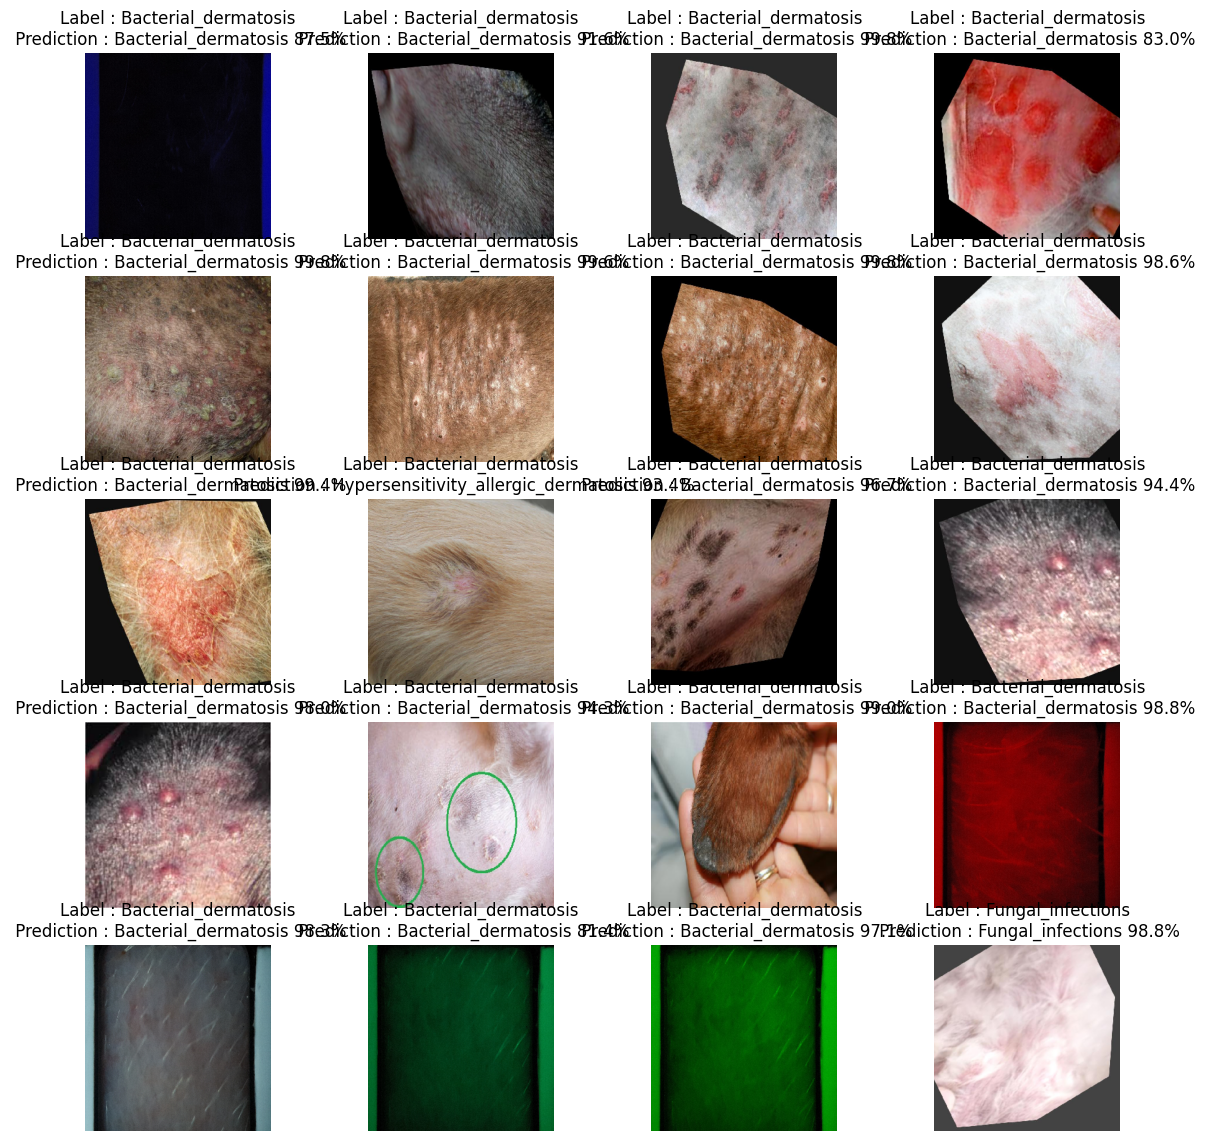

In [32]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(5):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


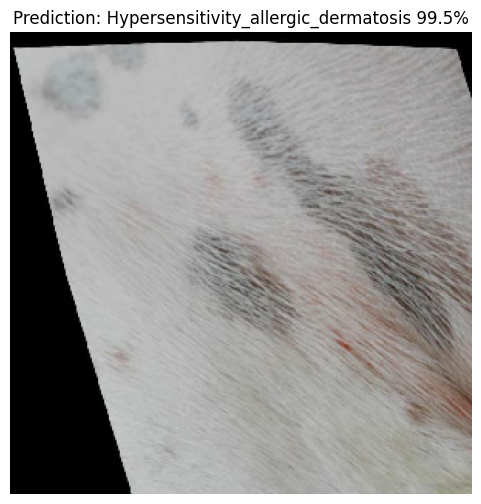

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # preprocesses the image using the same stats InceptionV3 was trained with
    return img_array

def predict_image(model, img_path, class_names):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)
    confidence = np.max(prediction)

    plt.figure(figsize=(6, 6))
    plt.imshow(image.load_img(img_path, target_size=(299, 299)))
    plt.axis('off')
    plt.title("Prediction: {} {:.1f}%".format(class_names[predicted_class[0]], 100 * confidence))
    plt.show()

# Usage example
img_path = '/content/dog-skin-disease-split/test/Hypersensitivity_allergic_dermatosis/Hypersensitivity4_png.rf.310082b28c9927ff0e62515861fceb60.jpg'  # Replace with your image path
class_names = ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']  # Replace with your actual class names
predict_image(model_Inception, img_path, class_names)
